# **Fase 2: Extracción de Características: Arcface + Resnet50**

- Instalación en CPU

In [3]:
!pip install -U insightface onnxruntime opencv-python pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.8 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp312-cp312-linux_x86_64.whl size=1070147 sha256=84c48ee4da45af4bff7e8ff99fb06ff3e74508ec32e2d4b15fe4822275168542
  Stored in directory: /root/.cache/pip/wheels/73/3c/e2/6d4815e8a8b33a2006554d65ce0d1f973e768f4c7a222fa675
Successfully built insightface


- Instalación en GPU

In [1]:
!pip install -U onnxruntime-gpu insightface opencv-python pillow

## **Importación Librerias**

In [5]:
import insightface
from insightface.model_zoo import get_model
from insightface.app import FaceAnalysis
import numpy as np
import cv2
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import onnxruntime as ort

### **Clase FaceEmbeddingVisualizer**

- Esta clase permite **cargar una imagen facial**, procesarla y generar su **vector de embeddings (512 dimensiones)** utilizando el modelo **ArcFace** de *InsightFace*.
- Su objetivo es facilitar la visualización y análisis del proceso de extracción de características faciales.
- Las principales funcionalidades son:

  - **Inicialización (`__init__`):**
    Carga la imagen desde una ruta dada, la convierte a formato RGB, la **redimensiona a 112×112 píxeles** (requisito de ArcFace), la **normaliza** y finalmente obtiene su **embedding** mediante el modelo de reconocimiento facial.

  - **`show_image()`:**
    Muestra la **imagen original** cargada.

  - **`show_image_resized()`:**
    Visualiza la **imagen redimensionada (112×112)** que se utiliza como entrada del modelo.

  - **`show_embedding(n=10)`:**
    Muestra por consola los **primeros valores** del vector de embedding (de un total de 512).

  - **`show_heatmap()`:**
    Genera un **mapa de calor** que representa gráficamente la intensidad de cada dimensión del embedding facial.

  - **`get_embedding()`:**
    Retorna el **vector de embedding** para ser utilizado en comparaciones o análisis de similitud.

In [6]:
class FaceEmbeddingVisualizer:
    def __init__(self, image_path, model, arcface):
        self.model = model
        self.arcface = arcface

        # Cargar imagen original
        self.image_path = image_path
        self.img_original = cv2.imread(image_path)
        self.img_original = cv2.cvtColor(self.img_original, cv2.COLOR_BGR2RGB)

        # Redimensionar y normalizar
        self.img_resized = cv2.resize(self.img_original, (112, 112))
        self.img_norm = self.img_resized.astype(np.float32) / 255.0

        # Extraer embedding
        self.embedding = self.arcface.get_feat([self.img_norm])[0]

    def show_image(self):
        plt.figure(figsize=(5,5))
        plt.imshow(self.img_original)
        plt.title("Imagen original")
        plt.axis("off")
        plt.show()

    def show_image_resized(self):
        plt.figure(figsize=(3,3))
        plt.imshow(self.img_resized)
        plt.title("Imagen 112×112")
        plt.axis("off")
        plt.show()

    def show_embedding(self, n=10):
        print(f"Embedding generado (dim {self.embedding.shape[0]})")
        print(f"Primeros {n} valores:\n{self.embedding[:n]}")

    def show_heatmap(self):
        plt.figure(figsize=(10,1.5))
        plt.imshow(self.embedding[np.newaxis, :], aspect='auto', cmap='plasma')
        plt.title("Mapa de calor del embedding (512D)")
        plt.xlabel("Dimensiones del embedding")
        plt.yticks([])
        plt.colorbar(label='Intensidad')
        plt.show()

    def get_embedding(self):
        return self.embedding

### **Carga del Modelo**

- Se carga el modelo preentrenado **`buffalo_l`** del paquete **InsightFace**, el cual incluye tres módulos principales:

  - **Detector:** encargado de localizar los rostros en la imagen.
  - **Landmark:** responsable de extraer los puntos faciales clave (ojos, nariz, comisuras, etc.).
  - **Recognition (ArcFace):** utilizado para generar los *embeddings* o representaciones vectoriales del rostro.
- Posteriormente, el modelo se prepara en el dispositivo correspondiente (**CPU** o **GPU**, según disponibilidad).
- Finalmente, se selecciona la fase **ArcFace** para la **extracción de embeddings faciales**, que serán utilizados en las comparaciones de similitud.


In [8]:
model = FaceAnalysis(name='buffalo_l')
model.prepare(ctx_id=0)
arcface = model.models['recognition']
print("Modelo ArcFace cargado correctamente.")

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

### **Configuración del Entorno de Ejecución (GPU)**

- Se configura y valida el entorno de ejecución de **ONNX Runtime** para utilizar la **GPU (CUDA)** disponible en el entorno, optimizando la velocidad del procesamiento.

In [9]:
print("Sesión ONNX ejecutándose en:", ort.get_device())
sess_options = ort.SessionOptions()
session = ort.InferenceSession(arcface.session._model_path, providers=['CUDAExecutionProvider'])
print("Proveedores de ejecución:", session.get_providers())


Sesión ONNX ejecutándose en: GPU
Proveedores de ejecución: ['CUDAExecutionProvider', 'CPUExecutionProvider']


## **Prueba**

- Se cargan una o varias imágenes desde el entorno de trabajo y se procesan mediante la clase **`FaceEmbeddingVisualizer`**, la cual genera la representación visual y numérica del rostro.
- Se muestran de forma secuencial la **imagen original**, la **imagen redimensionada a 112x112 píxeles**, los **valores iniciales del embedding (512D)** y el **mapa de calor** que representa gráficamente la distribución de características faciales extraídas.


Saving face_test.jpg to face_test (1).jpg


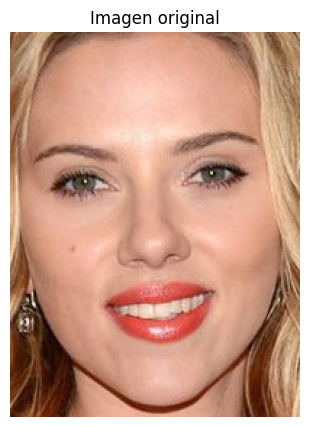

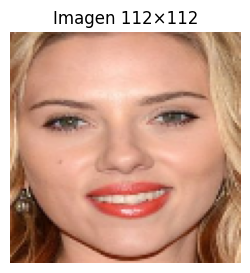

Embedding generado (dim 512)
Primeros 10 valores:
[-0.46020567 -0.6002785  -0.11139003  0.44122228  0.18675646 -0.2686155
  0.13036807 -0.5551945  -0.12654594 -0.11967557]


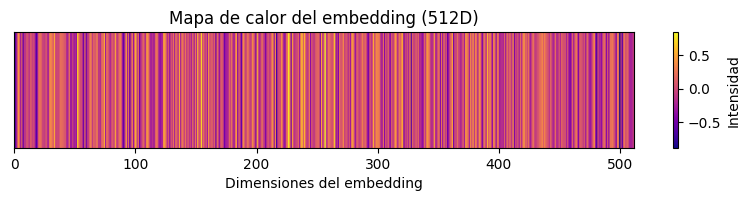

In [10]:
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
viz = FaceEmbeddingVisualizer(img_path, model, arcface)

viz.show_image()          # Imagen original
viz.show_image_resized()  # Imagen 112x112 + landmarks
viz.show_embedding()      # Primeros 10 valores
viz.show_heatmap()        # Mapa de calor

# **Fase 3: Comparación de Embeddings**

## **Función de Comparación por Similitud del Coseno**

- Calcula la **similitud del coseno** entre dos *embeddings* faciales para determinar si pertenecen a la **misma persona**.
- Para dos vectores ( A ) y ( B ), la similitud del coseno se define como:

  **similitud_coseno(A, B)** = **(A ⋅ B)÷(|A|⋅|B|)**


- El resultado se encuentra en el rango **[-1, 1]**:

  - **1.0 →** vectores idénticos (misma persona).
  - **0 →** sin relación (vectores ortogonales).
  - **-1 →** completamente opuestos (no ocurre en embeddings faciales).

- Si la similitud supera el **umbral definido (0.998)**, las imágenes se consideran de la **misma persona**; en caso contrario, corresponden a **personas diferentes**.


In [34]:
def similitud_coseno(emb1, emb2, umbral=0.998):
    # Normalizar (por si falta normalizar)
    emb1 = emb1 / np.linalg.norm(emb1)
    emb2 = emb2 / np.linalg.norm(emb2)

    sim = cosine_similarity([emb1], [emb2])[0][0]
    print(f"\tSimilaridad coseno: {sim:.5f}")
    if sim >= umbral:
        print(f"\tSe consideran la MISMA persona (≥ {umbral}).")
    else:
        print(f"\tSe consideran PERSONAS DIFERENTES (< {umbral}).")
    return sim

## **Test 2: Verificación de Similitud entre Imágenes de una Misma Persona**

- En esta prueba se utilizan **tres imágenes del mismo individuo** (frontal, izquierda y derecha) para evaluar la **consistencia de los embeddings** generados por el modelo **ArcFace**.
- Cada imagen es procesada mediante la clase **`FaceEmbeddingVisualizer`**, la cual genera la versión redimensionada del rostro y su correspondiente *embedding* vectorial.
- Posteriormente, se realizan **comparaciones por pares** entre las tres imágenes utilizando la **similitud del coseno**, con el fin de verificar que los valores obtenidos se mantengan **por encima del umbral**, lo que confirma que las tres representaciones pertenecen a la **misma persona**.


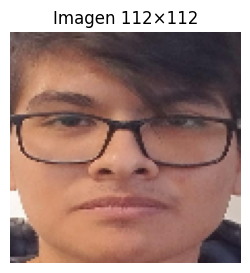

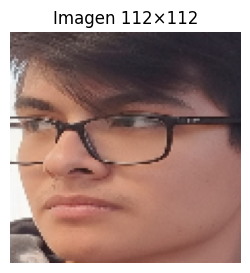

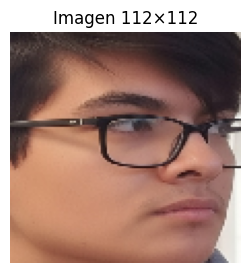

Imagen Frontal vs Imagen Izquierda:
	Similaridad coseno: 0.99881
	Se consideran la MISMA persona (≥ 0.998).
Imagen Frontal vs Imagen Derecha:
	Similaridad coseno: 0.99854
	Se consideran la MISMA persona (≥ 0.998).
Imagen Izquierda vs Imagen Derecha:
	Similaridad coseno: 0.99893
	Se consideran la MISMA persona (≥ 0.998).


np.float32(0.99893004)

In [35]:
# Tres de la misma persona
viz1 = FaceEmbeddingVisualizer("braulio_front_face_1.jpg", model, arcface)
viz1.show_image_resized()
viz2 = FaceEmbeddingVisualizer("braulio_left_face_1.jpg", model, arcface)
viz2.show_image_resized()
viz3 = FaceEmbeddingVisualizer("braulio_right_face_1.jpg", model, arcface)
viz3.show_image_resized()

# Comparaciones
print("Imagen Frontal vs Imagen Izquierda:")
similitud_coseno(viz1.get_embedding(), viz2.get_embedding())
print("Imagen Frontal vs Imagen Derecha:")
similitud_coseno(viz1.get_embedding(), viz3.get_embedding())
print("Imagen Izquierda vs Imagen Derecha:")
similitud_coseno(viz2.get_embedding(), viz3.get_embedding())

## **Test 3: Verificación de Diferencia entre Personas Distintas**

* En esta prueba se incorpora una **cuarta imagen perteneciente a una persona diferente**, con el objetivo de comprobar la **capacidad discriminativa** del modelo **ArcFace**.
* La nueva imagen se procesa mediante la clase **`FaceEmbeddingVisualizer`** para obtener su representación vectorial (*embedding*).
* Luego, se realizan **comparaciones entre los embeddings** de la persona original (frontal, izquierda y derecha) y la nueva imagen.
* Se espera que los valores de **similitud del coseno** sean **menores al umbral**, confirmando que el modelo **distingue correctamente entre individuos distintos**.

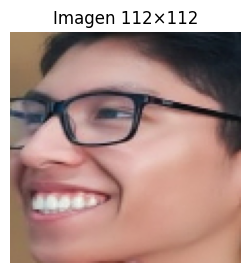

Imagen Frontal vs Distinta Persona:
	Similaridad coseno: 0.99688
	Se consideran PERSONAS DIFERENTES (< 0.998).
Imagen Izquierda vs Distinta Persona:
	Similaridad coseno: 0.99689
	Se consideran PERSONAS DIFERENTES (< 0.998).
Imagen Derecha vs Distinta Persona:
	Similaridad coseno: 0.99742
	Se consideran PERSONAS DIFERENTES (< 0.998).


np.float32(0.99742)

In [40]:
viz4 = FaceEmbeddingVisualizer("nelzon_left_face_1.jpg", model, arcface)
viz4.show_image_resized()

# Comparaciones
print("Imagen Frontal vs Distinta Persona:")
similitud_coseno(viz1.get_embedding(), viz4.get_embedding())
print("Imagen Izquierda vs Distinta Persona:")
similitud_coseno(viz2.get_embedding(), viz4.get_embedding())
print("Imagen Derecha vs Distinta Persona:")
similitud_coseno(viz3.get_embedding(), viz4.get_embedding())